In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
archivo1 = open("/content/drive/MyDrive/Proyecto física computacional II/frec_B0531.dat","r")
B0531 = archivo1.readlines()
archivo1.close()
archivo2 = open("/content/drive/MyDrive/Proyecto física computacional II/frec_B0833.dat","r")
B0833 = archivo2.readlines()
archivo2.close()
archivo3 = open("/content/drive/MyDrive/Proyecto física computacional II/frec_J0537.dat","r")
J0537 = archivo3.readlines()
archivo3.close()
archivo4 = open("/content/drive/MyDrive/Proyecto física computacional II/frec_J1819.dat","r")
J1819 = archivo4.readlines()
archivo4.close()

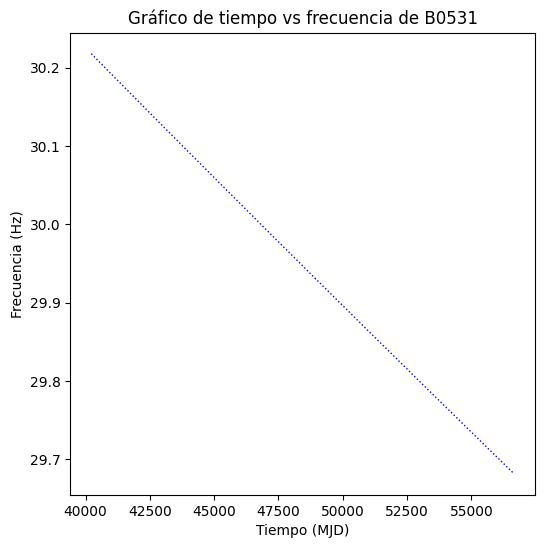

In [3]:
tiempoB0531 = []
frecuenciaB0531 = []
incertezaB0531 = []
for elem in B0531:
  x = elem.split()
  tiempoB0531.append(float(x[0]))
  frecuenciaB0531.append(float(x[1]))
  incertezaB0531.append(float(x[2]))

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()


Shape of A: (3, 3)
Shape of b: (3,)


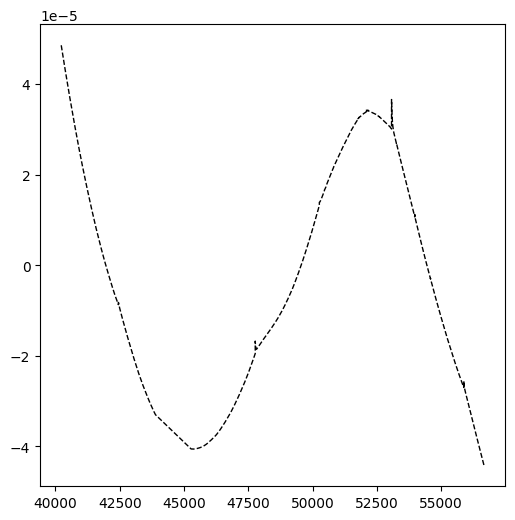

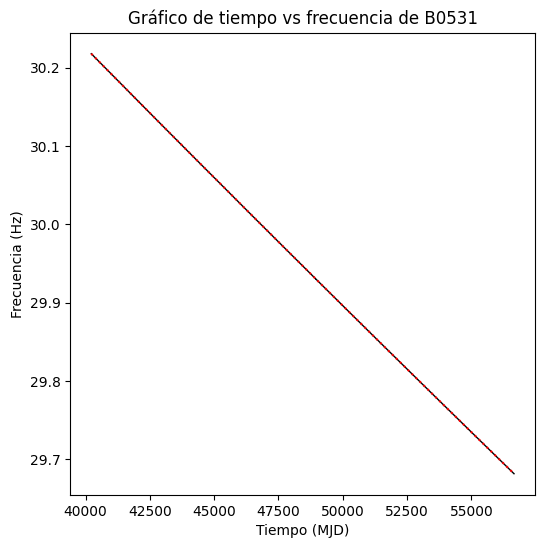

In [8]:
#Para B0531 hay que ajustar la frecuencia con una parábola, la regresión lineal no sirve

arrayTiempoB0531 = np.array(tiempoB0531)
arrayFrecuenciaB0531 = np.array(frecuenciaB0531)

n = len(arrayTiempoB0531)
x = np.sum(arrayTiempoB0531)
x2 = np.sum(arrayTiempoB0531 ** 2)
x3 = np.sum(arrayTiempoB0531 ** 3)
x4 = np.sum(arrayTiempoB0531 ** 4)
y = np.sum(arrayFrecuenciaB0531)
y2 = np.sum(arrayFrecuenciaB0531 ** 2)
y3 = np.sum(arrayFrecuenciaB0531 ** 3)
xy = np.sum(arrayTiempoB0531 * arrayFrecuenciaB0531)
x2y = np.sum((arrayTiempoB0531**2) * arrayFrecuenciaB0531)

matriz = np.array([[n,x,x2],[x,x2,x3],[x2,x3,x4]])
array = np.array([y,xy,x2y])

print(f"Shape of A: {matriz.shape}")
print(f"Shape of b: {array.shape}")

resultados = np.linalg.solve(matriz,array)

a0 = resultados[0]
a1 = resultados [1]
a2 = resultados[2]

# y = a0 + a1*x + a2*(x**2)

linea_tendenciaB0531 = a0 + a1*arrayTiempoB0531 + a2*( arrayTiempoB0531**2 )

glitches_B0531 = arrayFrecuenciaB0531-linea_tendenciaB0531

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoB0531,glitches_B0531,linewidth=1,color="black",linestyle="--")
plt.show()

# wea = [1,2,3,1] 1
"""
listax = []
for i in range(len(arrayFrecuenciaB0531-2)):
  if arrayFrecuenciaB0531[i]<arrayFrecuenciaB0531[i+1]:
      listax.append(arrayFrecuenciaB0531[i+1])

listax2 = []
for i in range(len(arrayFrecuenciaB0531)):
  if arrayFrecuenciaB0531[-i]<arrayFrecuenciaB0531[-i-1]:
    listax2.append(arrayFrecuenciaB0531[-i])
"""

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="black",linewidth=1,)
ax.plot(tiempoB0531, linea_tendenciaB0531,linestyle="dotted",color="red")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()


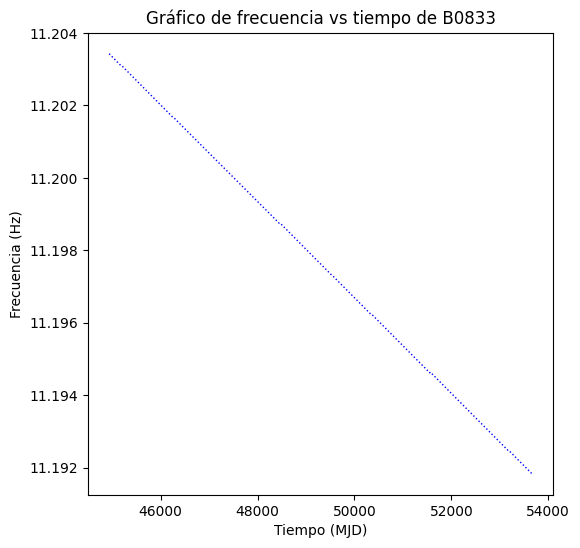

In [ ]:
tiempoB0833 = []
frecuenciaB0833 = []
for i in range(0,len(B0833)-1):
  x = B0833[i].split()
  tiempoB0833.append(float(x[0]))
  frecuenciaB0833.append(float(x[1]))

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0833,frecuenciaB0833,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -1.3283125060551748e-06
El intercepto es: 11.263116685094545


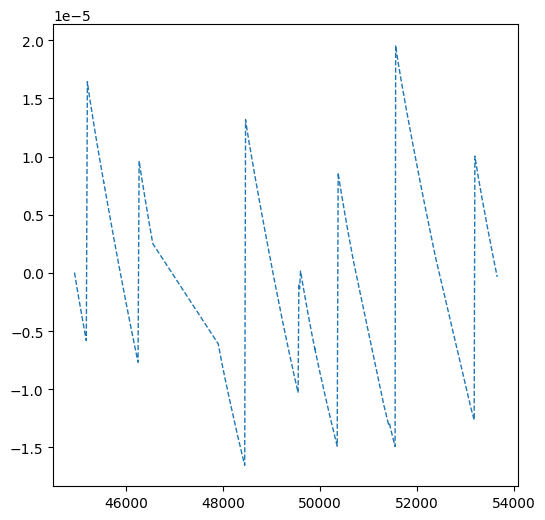

1.644201143768953e-05
1.6236426750637634e-05
1.599876679136969e-05
1.5671026355690287e-05
1.5551114463718818e-05
1.5463606665377938e-05
1.540560894675025e-05
1.5320171714350295e-05
1.5191368337497124e-05
1.4924600353793949e-05
1.4706053759638849e-05
1.460357739091478e-05
1.4524783287228615e-05
1.4428904600904957e-05
1.4315083131322126e-05
1.4121275301093306e-05
1.4020390297631025e-05
1.3824983104981925e-05
1.377011359515734e-05
1.367599907631245e-05
1.3647645692671517e-05
1.2629389582130557e-05
1.2519319364301396e-05
1.2401252936555807e-05
1.2284081263302937e-05
1.2096468630318213e-05
1.1944049946421842e-05
1.1797991474438163e-05
1.1666841935209504e-05
1.1494979599291355e-05
1.1380791402615387e-05
1.1323112207861641e-05
1.1261457842692835e-05
1.0344565565034713e-05
1.0261780746034788e-05
1.0174699715648217e-05
1.0049311979898334e-05
1.0344813563989419e-05
1.0262043746323002e-05
1.0174970714871279e-05
1.0049595980277104e-05
1.3185074235977368e-05
1.3041661407697802e-05
1.287745963374220

In [ ]:
arrayTiempoB0833 = np.array(tiempoB0833)
arrayFrecuenciaB0833 = np.array(frecuenciaB0833)

x = np.sum(arrayTiempoB0833)
y = np.sum(arrayFrecuenciaB0833)
xy = np.sum(arrayFrecuenciaB0833 * arrayTiempoB0833)
x2 = np.sum(arrayTiempoB0833 ** 2)
y2 = np.sum(arrayFrecuenciaB0833 ** 2)
m = (len(tiempoB0833) * xy - x * y) / (len(tiempoB0833) * x2 - (x ** 2))
print(f"La pendiente es: {m}")

b = (y*x2 - x*xy)/(len(tiempoB0833)*x2 - x**2)
print(f"El intercepto es: {b}")

linea_tendencia_B0833 = m*arrayTiempoB0833 + b

glitches_B0833 = arrayFrecuenciaB0833-linea_tendencia_B0833

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoB0833,glitches_B0833,linewidth=1,linestyle="--")
plt.show()


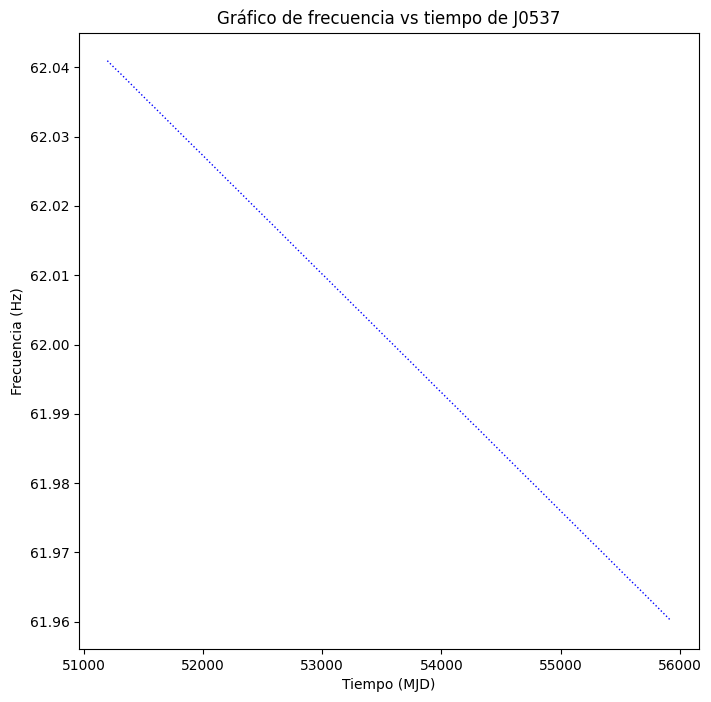

In [ ]:
tiempoJ0537 = []
frecuenciaJ0537 = []
incertezaJ0537 = []
for elem in J0537:
  x = elem.split()
  tiempoJ0537.append(float(x[0]))
  frecuenciaJ0537.append(float(x[1]))
  incertezaJ0537.append(float(x[2]))

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de J0537")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -1.7076871131872296e-05
El intercepto es: 62.915235345105486


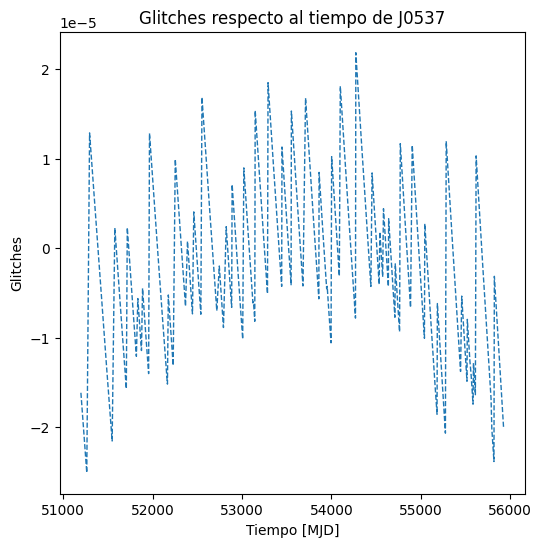

In [ ]:
arrayTiempoJ0537 = np.array(tiempoJ0537)
arrayFrecuenciaJ0537 = np.array(frecuenciaJ0537)

# y = mc + b
# n = 8
# x = semiejeCubo
# y = periodoCuadrado

x = np.sum(arrayTiempoJ0537)
y = np.sum(arrayFrecuenciaJ0537)
xy = np.sum(arrayFrecuenciaJ0537 * arrayTiempoJ0537)
x2 = np.sum(arrayTiempoJ0537 ** 2)
y2 = np.sum(arrayFrecuenciaJ0537 ** 2)
m = (len(tiempoJ0537) * xy - x * y) / (len(tiempoJ0537) * x2 - (x ** 2))
print(f"La pendiente es: {m}")

b = (y*x2 - x*xy)/(len(tiempoJ0537)*x2 - x**2)
print(f"El intercepto es: {b}")

linea_tendencia_J0537 = m*arrayTiempoJ0537 + b

glitches_J0537 = arrayFrecuenciaJ0537-linea_tendencia_J0537

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoJ0537,glitches_J0537,linewidth=1,linestyle="--")
ax.set_title("Glitches respecto al tiempo de J0537")
ax.set_xlabel("Tiempo [MJD]")
ax.set_ylabel("Glitches")
plt.show()

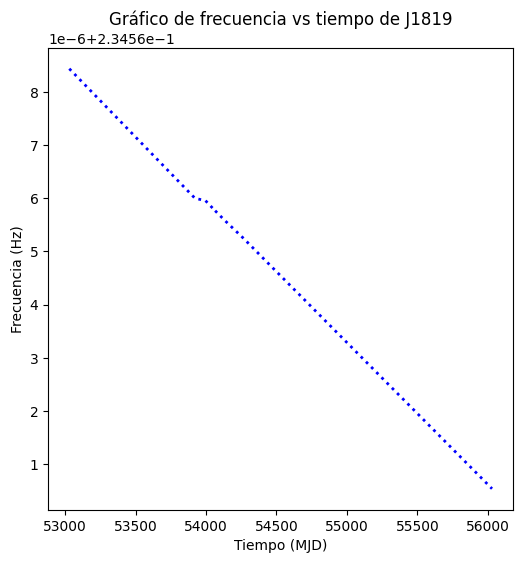

In [ ]:
tiempoJ1819 = []
frecuenciaJ1819 = []
for elem in J1819:
  x = elem.split()
  tiempoJ1819.append(float(x[0]))
  frecuenciaJ1819.append(float(x[1]))

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=2,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de J1819")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -2.625005831333755e-09
El intercepto es: 0.23470765044329833


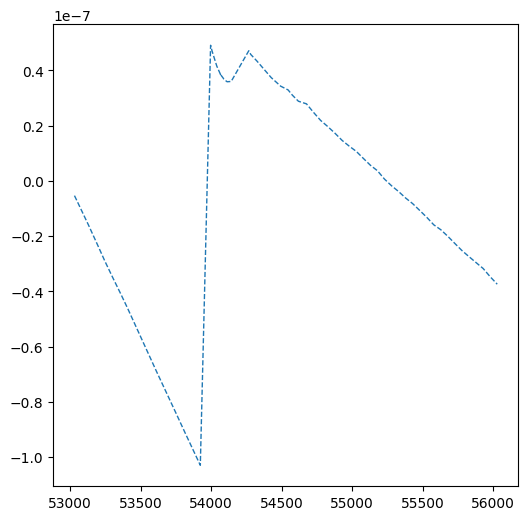

In [ ]:
arrayTiempoJ1819 = np.array(tiempoJ1819)
arrayFrecuenciaJ1819 = np.array(frecuenciaJ1819)

# y = mc + b
# n = 8
# x = semiejeCubo
# y = periodoCuadrado

xP = np.sum(arrayTiempoJ1819)
yP = np.sum(arrayFrecuenciaJ1819)
xyP = np.sum(arrayFrecuenciaJ1819 * arrayTiempoJ1819)
x2P = np.sum(arrayTiempoJ1819 ** 2)
y2P = np.sum(arrayFrecuenciaJ1819 ** 2)
m = (len(tiempoJ1819) * xyP - xP * yP) / (len(tiempoJ1819) * x2P - (xP ** 2))
print(f"La pendiente es: {m}")

b = (yP*x2P - xP*xyP)/(len(tiempoJ1819)*x2P - xP**2)
print(f"El intercepto es: {b}")

linea_tendencia_J1819 = m*arrayTiempoJ1819 + b

glitches_J1819 = arrayFrecuenciaJ1819-linea_tendencia_J1819

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoJ1819,glitches_J1819,linewidth=1,linestyle="--")
plt.show()